In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import reshape_data, get_dataset
import torch

In [2]:
get_dataset()

Dataset already downloaded!


In [3]:
data_path = 'data/dataset.npy'
number_degradations = 12
reshape_data(data_path, number_degradations)

Data reshaped successfully to shape: (12000, 2, 256, 256)


In [5]:
dataset = np.load(f'data/dataset_reshaped.npy', allow_pickle=True)
print(dataset.shape); print(len(dataset))

(12000, 2, 256, 256)
12000


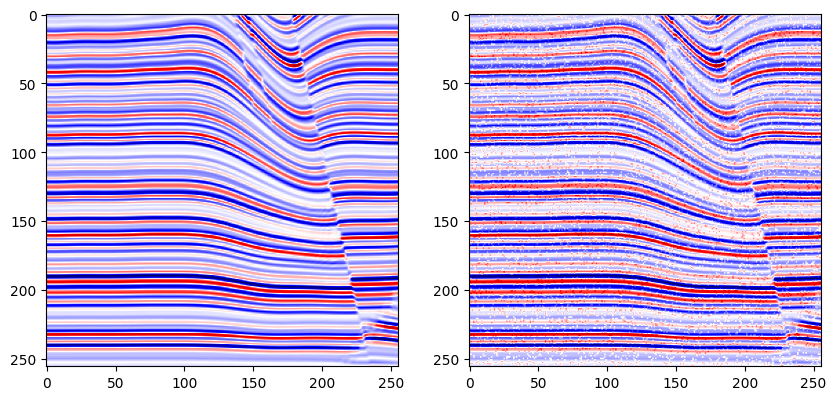

In [7]:
idx = 0
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(dataset[idx][0], cmap='seismic')
ax[1].imshow(dataset[idx][1], cmap='seismic')
plt.show()
